In [1]:
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Wedge, Arc, FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from pinn.geometry import compute_area, interp1d_multi_lines
from pinn.network import SofaNet

plt.rcParams['text.usetex'] = True

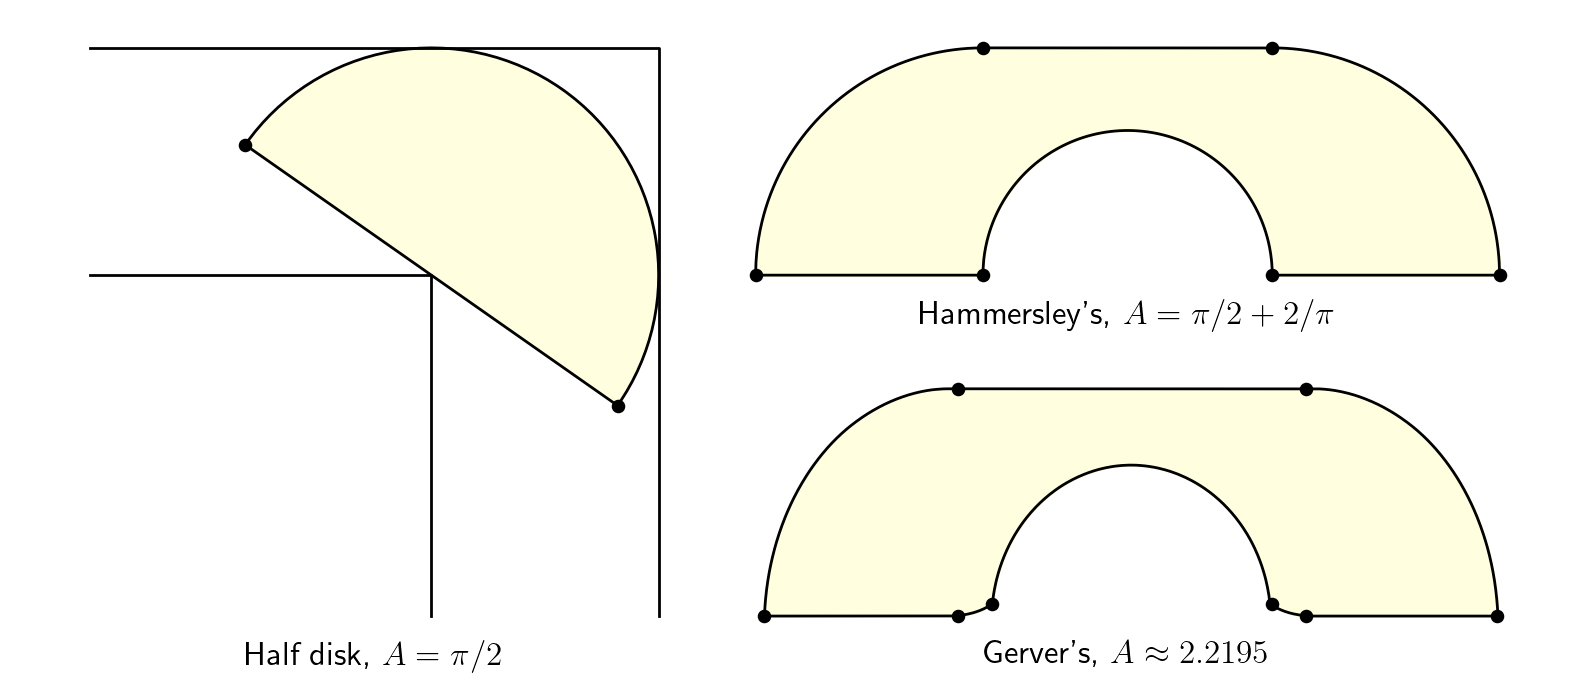

In [2]:
plt.figure(dpi=200, figsize=(10, 10))
ax = plt.gca()
L = 1.5
fs = 12
ms = 15

ax.plot([-L, 0, 0], [0, 0, -L], c="k", lw=1)
ax.plot([-L, 1, 1], [1, 1, -L], c="k", lw=1)
angle = torch.tensor(35.)
ax.add_patch(Wedge((0, 0), 1, -angle, 180 - angle, facecolor="lightyellow", edgecolor="k", lw=1))
ax.scatter(-torch.cos(torch.deg2rad(angle)), torch.sin(torch.deg2rad(angle)), c='k', s=ms, zorder=1000)
ax.scatter(torch.cos(torch.deg2rad(angle)), -torch.sin(torch.deg2rad(angle)), c='k', s=ms, zorder=1000)
ax.text((1 - L) / 2, -L - .1, "Half disk, $A=\pi/2$", ha="center", va="top", fontsize=fs)

x0 = 3.7
ax = plt.gca()
t = torch.linspace(0, 1, 100)
alpha = torch.linspace(0, torch.pi / 2, 100)
a = b = 2 / torch.pi
xp = a * (torch.cos(2 * alpha) - 1)
yp = b * torch.sin(2 * alpha)
dt_alpha = torch.ones_like(alpha) * torch.pi / 2
dt_xp = -a * 2 * torch.sin(2 * alpha) * dt_alpha
dt_yp = b * 2 * torch.cos(2 * alpha) * dt_alpha
gg = compute_area(t, alpha, xp, yp, dt_alpha, dt_xp, dt_yp, return_geometry=True)
plt.plot(x0 + gg["x_sample"], gg["y_sample_lower"], lw=1, c='k')
plt.plot(x0 + gg["x_sample"], gg["y_sample_upper"], lw=1, c='k')
plt.scatter(x0 + torch.tensor([0, 1, 0, -2 * a, -2 * a - 1, -2 * a]),
            [0, 0, 1, 0, 0, 1], c='k', s=ms, zorder=1000)
plt.fill_between(x0 + gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                 color='lightyellow')
xt = x0 + (xp[0] + xp[-1]) / 2
ax.text(xt, - .1, "Hammersley’s, $A=\pi/2+2/\pi$", ha="center", va="top", fontsize=fs)

y0 = -1.5
gg = torch.load("figs/data/pinn_geometry.pt")
for key in gg.keys():
    gg[key] = gg[key].detach()
mid2 = gg["x_sample"][0] + gg["x_sample"][-1]
plt.plot(x0 + gg["x_sample"], y0 + gg["y_sample_lower"], lw=1, c='k')
plt.plot(x0 + gg["x_sample"], y0 + gg["y_sample_upper"], lw=1, c='k')
xe = torch.stack([x0 + gg["x_ehi"], y0 + gg["y_ehi"]], dim=1)
xp = torch.stack([x0 + gg["xp"], y0 + gg["yp"]], dim=1)
dist = torch.min(torch.norm(xe[:, None] - xp[None, :], dim=-1), dim=1)[0]
intersect = dist.argmin()
plt.scatter(x0 + torch.tensor([gg["x_sample"][0], gg["x_ehi"][0], gg["x_ehi"][intersect], gg["x_eho"][0]]),
            y0 + torch.tensor([gg["y_sample_lower"][0], gg["y_ehi"][0], gg["y_ehi"][intersect], gg["y_eho"][0]]),
            c='k', s=ms, zorder=1000)
plt.scatter(
    x0 + torch.tensor(
        [mid2 - gg["x_sample"][0] - .01, mid2 - gg["x_ehi"][0], mid2 - gg["x_ehi"][intersect], mid2 - gg["x_eho"][0]]),
    y0 + torch.tensor([gg["y_sample_lower"][0], gg["y_ehi"][0], gg["y_ehi"][intersect], gg["y_eho"][0]]),
    c='k', s=ms, zorder=1000)
plt.fill_between(x0 + gg["x_sample"], y1=y0 + gg["y_sample_upper"], y2=y0 + gg["y_sample_lower"],
                 color='lightyellow')
ax.text(xt, y0 - .1, "Gerver’s, $A\\approx2.2195$", ha="center", va="top", fontsize=fs)

ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/intro.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

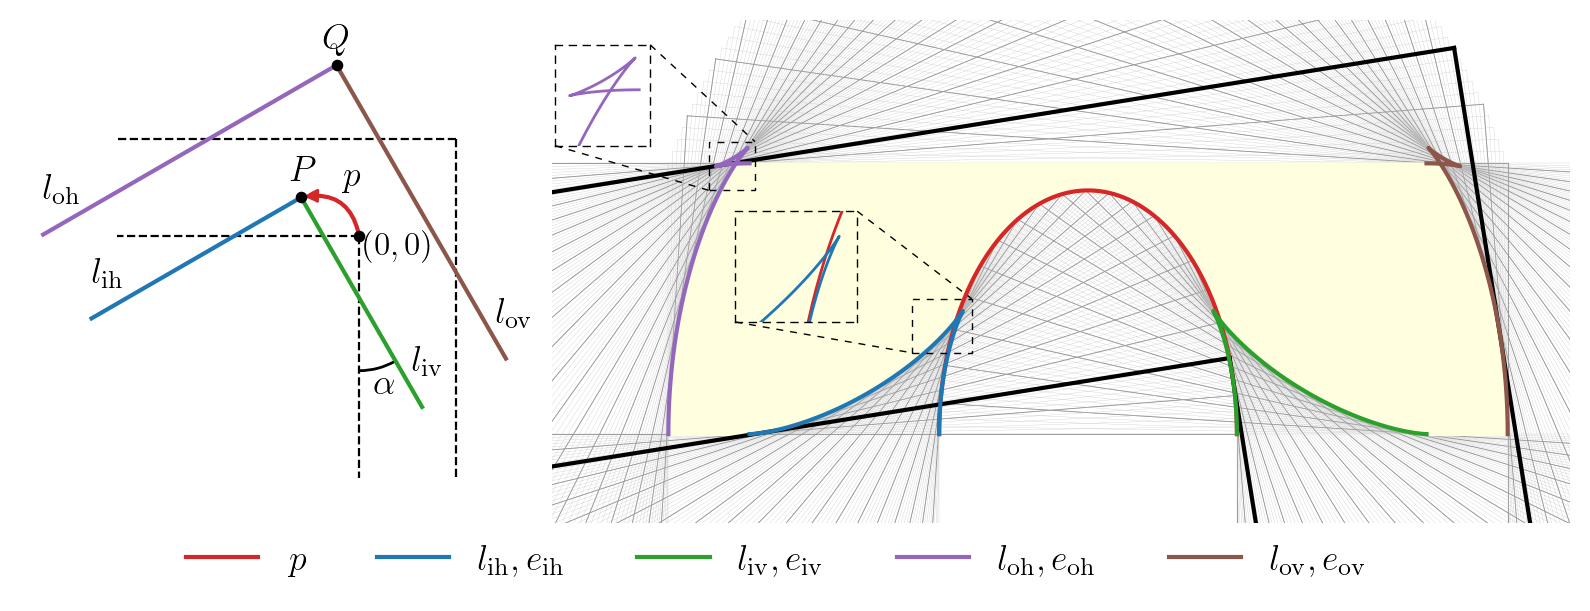

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
cp = colors[3]
cih = colors[0]
civ = colors[2]
coh = colors[4]
cov = colors[5]

fig, axes = plt.subplots(1, 2, dpi=200, figsize=(10, 10), gridspec_kw={'width_ratios': [1., 2.]})
plt.subplots_adjust(wspace=0.03)
ax = axes[0]
h = 2.5
a = torch.deg2rad(torch.tensor(30))
dx = -.6
dy = .4
fs = 13


def trans(p):
    x0, y0 = p
    x1 = x0 * torch.cos(a) - y0 * torch.sin(a)
    y1 = x0 * torch.sin(a) + y0 * torch.cos(a)
    return torch.tensor([x1 + dx, y1 + dy])


P = torch.tensor([0, 0])
Q = torch.tensor([1, 1])
A = torch.tensor([-h, 0])
B = torch.tensor([0, -h])
C = torch.tensor([-h, 1])
D = torch.tensor([1, -h])
ax.plot(*torch.stack((P, A)).T, ls='--', lw=.8, c='k')
ax.plot(*torch.stack((P, B)).T, ls='--', lw=.8, c='k')
ax.plot(*torch.stack((Q, C)).T, ls='--', lw=.8, c='k')
ax.plot(*torch.stack((Q, D)).T, ls='--', lw=.8, c='k')
ax.plot(*torch.stack((trans(P), trans(A))).T, lw=1.5, c=cih)
ax.plot(*torch.stack((trans(P), trans(B))).T, lw=1.5, c=civ)
ax.plot(*torch.stack((trans(Q), trans(C))).T, lw=1.5, c=coh)
ax.plot(*torch.stack((trans(Q), trans(D))).T, lw=1.5, c=cov)

P = trans(P)
Q = trans(Q)
A = trans(A)
B = trans(B)
C = trans(C)
D = trans(D)

xPB = torch.linspace(P[0], B[0], 1000)
yPB = torch.linspace(P[1], B[1], 1000)
loc = torch.argmin(torch.abs(xPB))
y_cen = yPB[loc]
arc = Arc([0, y_cen], 1.5, 1.5, angle=0.0, theta1=270.0, theta2=270.0 + torch.rad2deg(a), lw=1, color='k')
ax.add_patch(arc)

style = "Simple, tail_width=0.5, head_width=4, head_length=4"
kw = dict(arrowstyle=style, color=cp)
path = FancyArrowPatch((0, 0), (dx, dy), connectionstyle="arc3,rad=.5", **kw)
ax.add_patch(path)

ax.scatter([0, P[0], Q[0]],
           [0, P[1], Q[1]], c='k', s=10, zorder=1000)

ax.text(Q[0], Q[1] + .1, "$Q$", ha="center", va="bottom", fontsize=fs)
ax.text(P[0], P[1] + .1, "$P$", ha="center", va="bottom", fontsize=fs)
ax.text(0 + .05, -.1, "$(0, 0)$", ha="left", va="center", fontsize=12)
ax.text(0 + .15, y_cen - 0.9, "$\\alpha$", ha="left", va="center", fontsize=fs)
ax.text(P[0] / 2 + .2, P[1] / 2 + .25, "$p$", ha="center", va="bottom", fontsize=fs)
ax.text(A[0], A[1] + .3, "$l_\\mathrm{ih}$", ha="left", va="bottom", fontsize=fs)
ax.text(B[0] - .1, B[1] + .3, "$l_\\mathrm{iv}$", ha="left", va="bottom", fontsize=fs)
ax.text(C[0], C[1] + .3, "$l_\\mathrm{oh}$", ha="left", va="bottom", fontsize=fs)
ax.text(D[0] - .1, D[1] + .3, "$l_\\mathrm{ov}$", ha="left", va="bottom", fontsize=fs)

ax.set_aspect(1.)
ax.axis("off")

ax = axes[1]
N = 100
S = 5
t = torch.linspace(0, 1, N)
alpha = torch.linspace(0, torch.pi / 2, N)
a = .55
b = .9
xp = a * (torch.cos(2 * alpha) - 1)
yp = b * torch.sin(2 * alpha)
dt_alpha = torch.ones_like(alpha) * torch.pi / 2
dt_xp = -a * 2 * torch.sin(2 * alpha) * dt_alpha
dt_yp = b * 2 * torch.cos(2 * alpha) * dt_alpha
gg = compute_area(t, alpha, xp, yp, dt_alpha, dt_xp, dt_yp, return_geometry=True)

for i in range(0, len(t), 1):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.1, c='silver', zorder=-100)

for i in range(0, len(t), S):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.3, c='gray', zorder=-200)

i = 10
ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=1.5, c='k', zorder=100)

ax.plot(gg["xp"], gg["yp"], lw=1.5, c=cp, label="$p$")
ax.plot(gg["x_ehi"], gg["y_ehi"], lw=1.5, c=cih, zorder=200, label="$l_\mathrm{ih}, e_\mathrm{ih}$")
ax.plot(gg["x_evi"], gg["y_evi"], lw=1.5, c=civ, zorder=200, label="$l_\mathrm{iv}, e_\mathrm{iv}$")
ax.plot(gg["x_eho"], gg["y_eho"], lw=1.5, c=coh, zorder=200, label="$l_\mathrm{oh}, e_\mathrm{oh}$")
ax.plot(gg["x_evo"], gg["y_evo"], lw=1.5, c=cov, zorder=200, label="$l_\mathrm{ov}, e_\mathrm{ov}$")
ax.legend(loc="lower center", ncol=5,
          bbox_to_anchor=(0.22, -.17), fontsize=fs, frameon=False)

ax_up = ax.inset_axes(
    [-0.05, 0.75, 0.2, 0.2],
    xlim=(-1.95, -1.78), ylim=(.9, 1.08), xticks=[], yticks=[])
ax_up.plot(gg["x_eho"], gg["y_eho"], lw=1, c=coh)
ax_up.set_aspect(1.)
ax_up.set_xticks([])
ax_up.set_yticks([])
plt.setp(ax_up.spines.values(), lw=0.5, ls=(0, (5, 5)))
mark_inset(ax, ax_up, loc1=1, loc2=3, fc="none", ec="k", ls=(0, (5, 5)), lw=0.5, zorder=1000)

ax_lo = ax.inset_axes(
    [0.13, 0.40, 0.22, 0.22],
    xlim=(-1.1 - .1, -1.0 + .02), ylim=(.3, .5), xticks=[], yticks=[])
ax_lo.plot(gg["xp"], gg["yp"], lw=1, c=cp, label="$p$")
ax_lo.plot(gg["x_ehi"], gg["y_ehi"], lw=1, c=cih)
ax_lo.set_aspect(1.)
ax_lo.set_xticks([])
ax_lo.set_yticks([])
ax_lo.set_facecolor('lightyellow')
plt.setp(ax_lo.spines.values(), lw=0.5, ls=(0, (5, 5)))
mark_inset(ax, ax_lo, loc1=1, loc2=3, fc="none", ec="k", ls=(0, (5, 5)), lw=0.5, zorder=1000)

ax.fill_between(gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                color='lightyellow')

ax.set_xlim(gg["x_sample"][0] - .03 - .4, gg["x_sample"][-1] + .03 + .2)
ax.set_ylim(-.03 - .3, 1 + .03 + .5)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/geometry.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

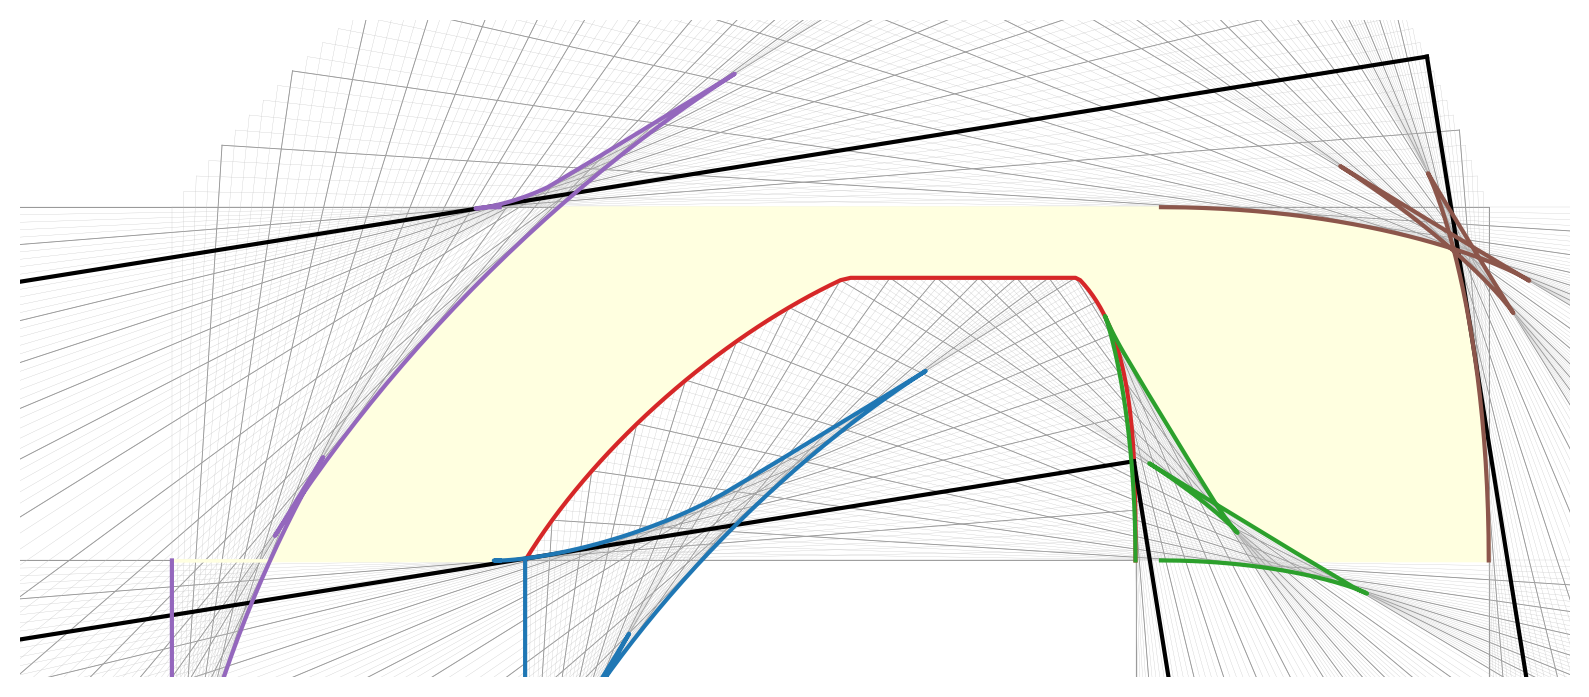

In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
cp = colors[3]
cih = colors[0]
civ = colors[2]
coh = colors[4]
cov = colors[5]

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
alpha = torch.linspace(0, torch.pi / 2, N)
xp = a * (torch.cos(2 * alpha) - 1)
yp = b * torch.sin(2 * alpha)
xp *= alpha
yp = torch.clamp(yp, None, 0.8)
N = 100
S = 5
t = torch.linspace(0, 1, N)
a = .55
b = .9
dt_alpha = torch.ones_like(alpha) * torch.pi / 2
dt_xp = -a * 2 * torch.sin(2 * alpha) * dt_alpha
dt_yp = b * 2 * torch.cos(2 * alpha) * dt_alpha
dt_xp[1:-1] = (xp[2:] - xp[:-2]) / (2 * (1 / N))
dt_yp[1:-1] = (yp[2:] - yp[:-2]) / (2 * (1 / N))
gg = compute_area(t, alpha, xp, yp, dt_alpha, dt_xp, dt_yp, return_geometry=True)

for i in range(0, len(t), 1):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.1, c='silver', zorder=-100)
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.1, c='silver', zorder=-100)

for i in range(0, len(t), S):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=.3, c='gray', zorder=-200)
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=.3, c='gray', zorder=-200)

i = 10
ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lho"][i], gg["y_lho"][i], lw=1.5, c='k', zorder=100)
ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], lw=1.5, c='k', zorder=100)

ax.plot(gg["xp"], gg["yp"], lw=1.5, c=cp, label="$p$")
ax.plot(gg["x_ehi"], gg["y_ehi"], lw=1.5, c=cih, zorder=200, label="$l_\mathrm{ih}, e_\mathrm{ih}$")
ax.plot(gg["x_evi"], gg["y_evi"], lw=1.5, c=civ, zorder=200, label="$l_\mathrm{iv}, e_\mathrm{iv}$")
ax.plot(gg["x_eho"], gg["y_eho"], lw=1.5, c=coh, zorder=200, label="$l_\mathrm{oh}, e_\mathrm{oh}$")
ax.plot(gg["x_evo"], gg["y_evo"], lw=1.5, c=cov, zorder=200, label="$l_\mathrm{ov}, e_\mathrm{ov}$")
ax.fill_between(gg["x_sample"], y1=gg["y_sample_upper"], y2=gg["y_sample_lower"],
                color='lightyellow')

ax.set_xlim(gg["x_sample"][0] - .03 - .4, gg["x_sample"][-1] + .03 + .2)
ax.set_ylim(-.03 - .3, 1 + .03 + .5)
ax.set_aspect(1.)
ax.axis("off")
plt.savefig("figs/chaotic.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

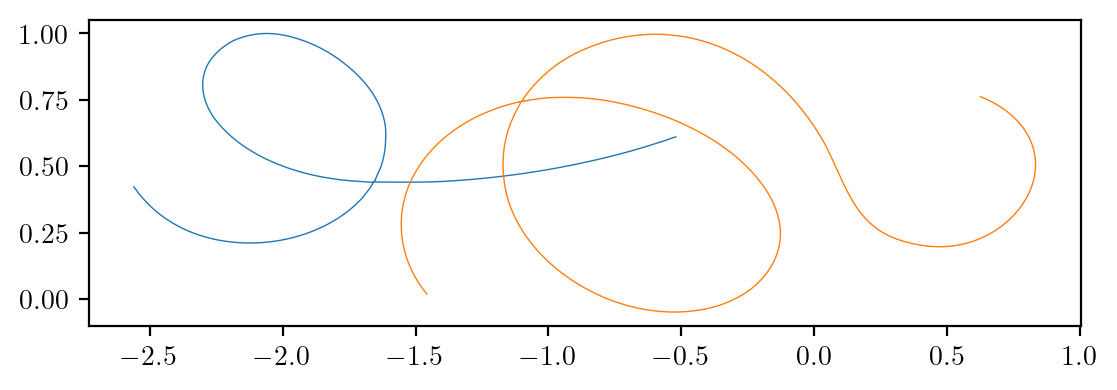

In [5]:
from svg.path import parse_path

c1 = "M285.5 4.5C323.5 -0.5 363.5 12.5 397 29.5C428 45 455 66 479.5 90.5C521.5 132.5 553.5 183.5 565 242.5C569 260.5 569.5 278.5 569 296.5C568.5 325 565.5 353 557 380.5C553.5 390.5 550 400 546.5 410C545.5 413 545 419 541.5 419.5C533 421 522.5 418.5 514 418C493 416.5 472 414.5 451.5 410.5C346 391.5 242.5 336.5 186 242.5C157 193.5 148 130 176 78.5C183 66.5 191.5 55 201.5 45C210.5 36 221 27 232.5 21C249.5 12 266.5 7 285.5 4.5M544.5 419.5C597 419.5 649.5 421 701.5 417.5C802 410.5 902.5 394 1000 368.5C1049.5 355.5 1098.5 340.5 1146 322.5C1162 316 1178.5 310 1194.5 303.5C1203.5 299.5 1213 294.5 1222.5 292M541 420.5C537.5 430 532.5 439 527 447.5C513.5 470.5 495.5 491.5 476 509C382.5 593.5 242 616 129.5 558C94 539.5 61.5 512.5 37 481C29.5 471.5 22 461.5 15.5 451C12 445 9 438.5 4.5 433"
c2 = "M62.5 735C2 645.5 -12.5 526.5 22.5 424.5C43.5 364 80 310 129 268.5C159.5 242.5 194 222.5 231 207.5C239.5 204 248.5 201 257.5 198C261 197 266 195 269.5 195.5C273.5 196 267.5 206.5 266.5 208.5C260 222.5 255 237 250 251.5C229.5 314 227.5 382 238.5 446.5C259.5 566.5 340 674.5 444.5 735C521.5 780 614.5 798 701 770.5C723 763.5 743.5 752.5 762.5 739.5C822 698 858 623.5 853 551C850.5 512 838 473 819.5 438.5C752 313.5 618.5 229.5 483 196C434.5 183.5 384.5 180 334.5 183.5C320 184.5 305.5 187 291 190C288 190.5 278.5 194 276.5 192C275 190.5 277 187.5 277.5 186C280.5 180.5 283.5 175.5 286.5 170.5C317.5 120 361.5 75 414.5 47.5C446.5 30.5 480 17.5 516 11C540 7 564.5 4.5 589 6C614 8 638.5 11.5 662.5 19C795 59 891.5 179.5 947.5 301C973.5 358.5 989.5 420 1017 476.5C1034.5 513 1059.5 547.5 1094.5 569C1118 583 1145 592 1171.5 597C1190 600.5 1209 601.5 1227.5 600C1346.5 588.5 1435 467 1424 350.5C1416.5 273.5 1366.5 211 1297.5 178.5M271 195.5L275 192.5"


def get_points(string, n_points):
    p = parse_path(string)
    points = []
    for x in torch.linspace(0., 1., n_points):
        points.append(p.point(x))
    points = torch.tensor(points)
    x = torch.real(points)
    y = -torch.imag(points)
    dx = torch.diff(x)
    dy = torch.diff(y)
    length = torch.sqrt(dx ** 2 + dy ** 2)
    splits = torch.where(length > 50)[0]
    splits = torch.cat((torch.tensor(0).unsqueeze(0),
                        splits,
                        torch.tensor(n_points).unsqueeze(0)))
    sections = []
    for i in range(len(splits) - 1):
        sections.append(torch.stack((x[splits[i] + 1:splits[i + 1]], y[splits[i] + 1:splits[i + 1]]), dim=-1))
    return sections


sections1 = get_points(c1, 1000)
s0 = sections1[1].flip(dims=[0])
s1 = sections1[0]
start = torch.argmin(torch.norm(s1 - s0[-1], dim=1))
s1 = torch.cat((s1[start:], s1[0:start]), dim=0)
s2 = sections1[2]
curve1 = torch.cat([s0, s1, s2], dim=0)

sections2 = get_points(c2, 2000)
curve2 = sections2[0]
norm = torch.norm(curve2 - sections2[1][1], dim=1)
loc = torch.where(torch.logical_and(norm[2:] - norm[1:-1] > 0, norm[0:-2] - norm[1:-1] > 0))[0] - 1
curve2[loc[0]] = sections2[1][1]
curve2[loc[1]] = sections2[1][1]
curve2[:, 0] += 600

margin = 100
right = curve2[:, 0].max() + margin
left = curve1[:, 0].min() - margin
curve1 = (gg["x_sample"][-1] - gg["x_sample"][0]) / (right - left) * (curve1 - left) + gg["x_sample"][0]
curve2 = (gg["x_sample"][-1] - gg["x_sample"][0]) / (right - left) * (curve2 - left) + gg["x_sample"][0]
top = curve1[:, 1].max()
curve1[:, 1] += -top
curve2[:, 1] += -top
curve1[:, 1] *= .8
curve2[:, 1] *= .8
curve1[:, 1] += 1
curve2[:, 1] += 1

plt.figure(dpi=200)
plt.plot(curve1[:, 0], curve1[:, 1], lw=.5)
plt.plot(curve2[:, 0], curve2[:, 1], lw=.5)
plt.gca().set_aspect(1.)
plt.show()

In [6]:
from pinn.geometry import interp1d_multi_section_curve

x_target = gg["x_sample"]
ms1_min = interp1d_multi_section_curve(curve1[:, 0], curve1[:, 1], x_target, min_for_reduce=True)
ms1_max = interp1d_multi_section_curve(curve1[:, 0], curve1[:, 1], x_target, min_for_reduce=False)
ms2_min = interp1d_multi_section_curve(curve2[:, 0], curve2[:, 1], x_target, min_for_reduce=True)
ms2_max = interp1d_multi_section_curve(curve2[:, 0], curve2[:, 1], x_target, min_for_reduce=False)
as_lower = torch.maximum(ms1_max, ms2_max)
as_upper = torch.minimum(ms1_min, ms2_min)
as_lower = as_lower.clip(-100, 100)
as_upper = as_upper.clip(-100, 100)


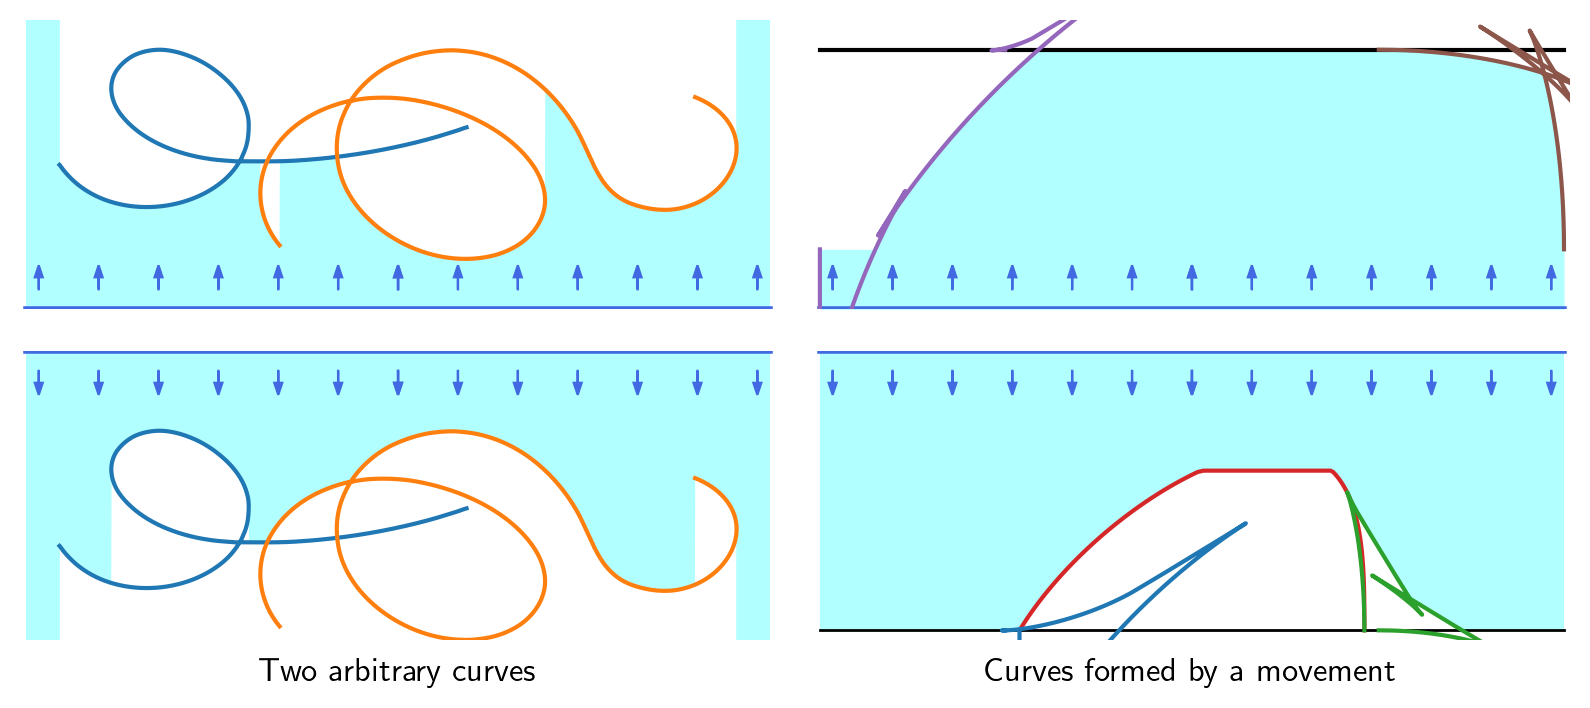

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=200, figsize=(10, 4.3))
plt.subplots_adjust(wspace=.05, hspace=0.)
extra = .3
alpha = .3
arrow = .3

ax = ax1
ax.plot(curve1[:, 0], curve1[:, 1], lw=1.5)
ax.plot(curve2[:, 0], curve2[:, 1], lw=1.5)
ax.fill_between(x_target, y1=torch.zeros_like(x_target) - 100, y2=as_upper,
                color='aqua', alpha=alpha, lw=0)
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-extra, 1 + .1 + .05)
ax.set_aspect(1.)
ax.axis("off")
mid = (gg["x_sample"][0] + gg["x_sample"][-1]) / 2
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [-extra, -extra], c="royalblue", lw=2)
for x in torch.arange(mid, gg["x_sample"][-1], arrow):
    ax.arrow(x, -extra + .1, 0, .06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")
    ax.arrow(2 * mid - x, -extra + .1, 0, .06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")

ax = ax3
ax.plot(curve1[:, 0], curve1[:, 1], lw=1.5)
ax.plot(curve2[:, 0], curve2[:, 1], lw=1.5)
ax.fill_between(x_target, y1=as_lower, y2=torch.zeros_like(x_target) + 100,
                color='aqua', alpha=alpha, lw=0)
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
top = 1.1 + extra
ax.set_ylim(top - (1 + .1 + extra) - 0.05, top)
ax.set_aspect(1.)
ax.axis("off")
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [1 + extra + .1, 1 + extra + .1], c="royalblue", lw=2)
for x in torch.arange(mid, gg["x_sample"][-1], arrow):
    ax.arrow(x, top - .1, 0, -.06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")
    ax.arrow(2 * mid - x, top - .1, 0, -.06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")
ax.set_title("Two arbitrary curves", y=-0.2)

ax = ax2
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [1, 1], lw=1.5, c='k')
ax.plot(gg["x_eho"], gg["y_eho"], lw=1.5, c=coh, zorder=200)
ax.plot(gg["x_evo"], gg["y_evo"], lw=1.5, c=cov, zorder=200)
ax.fill_between(gg["x_sample"], y1=torch.zeros_like(gg["y_sample_upper"]) - extra, y2=gg["y_sample_upper"],
                color='aqua', alpha=alpha, lw=0)
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
ax.set_ylim(-extra, 1 + .1 + .05)
ax.set_aspect(1.)
ax.axis("off")
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [-extra, -extra], c="royalblue", lw=2)
for x in torch.arange(mid, gg["x_sample"][-1], arrow):
    ax.arrow(x, -extra + .1, 0, .06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")
    ax.arrow(2 * mid - x, -extra + .1, 0, .06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")

ax = ax4
ax.plot(gg["xp"], gg["yp"], lw=1.5, c=cp, label="$p$")
ax.plot(gg["x_ehi"], gg["y_ehi"], lw=1.5, c=cih, zorder=200)
ax.plot(gg["x_evi"], gg["y_evi"], lw=1.5, c=civ, zorder=200)
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [0, 0], lw=1, c='k')
ax.fill_between(gg["x_sample"], y1=torch.ones_like(gg["x_sample"]) + 100, y2=gg["y_sample_lower"],
                color='aqua', alpha=alpha, lw=0)
ax.set_xlim(gg["x_sample"][0] - .03, gg["x_sample"][-1] + .03)
top = 1.1 + extra
ax.set_ylim(top - (1.1 + extra) - .05, top)
ax.set_aspect(1.)
ax.axis("off")
ax.plot([gg["x_sample"][0], gg["x_sample"][-1]], [1 + extra + .1, 1 + extra + .1], c="royalblue", lw=2)
for x in torch.arange(mid, gg["x_sample"][-1], arrow):
    ax.arrow(x, top - .1, 0, -.06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")
    ax.arrow(2 * mid - x, top - .1, 0, -.06, lw=.8, head_width=.04, facecolor='royalblue', edgecolor="royalblue")

ax.set_title("Curves formed by a movement", y=-0.2)
plt.savefig("figs/water.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

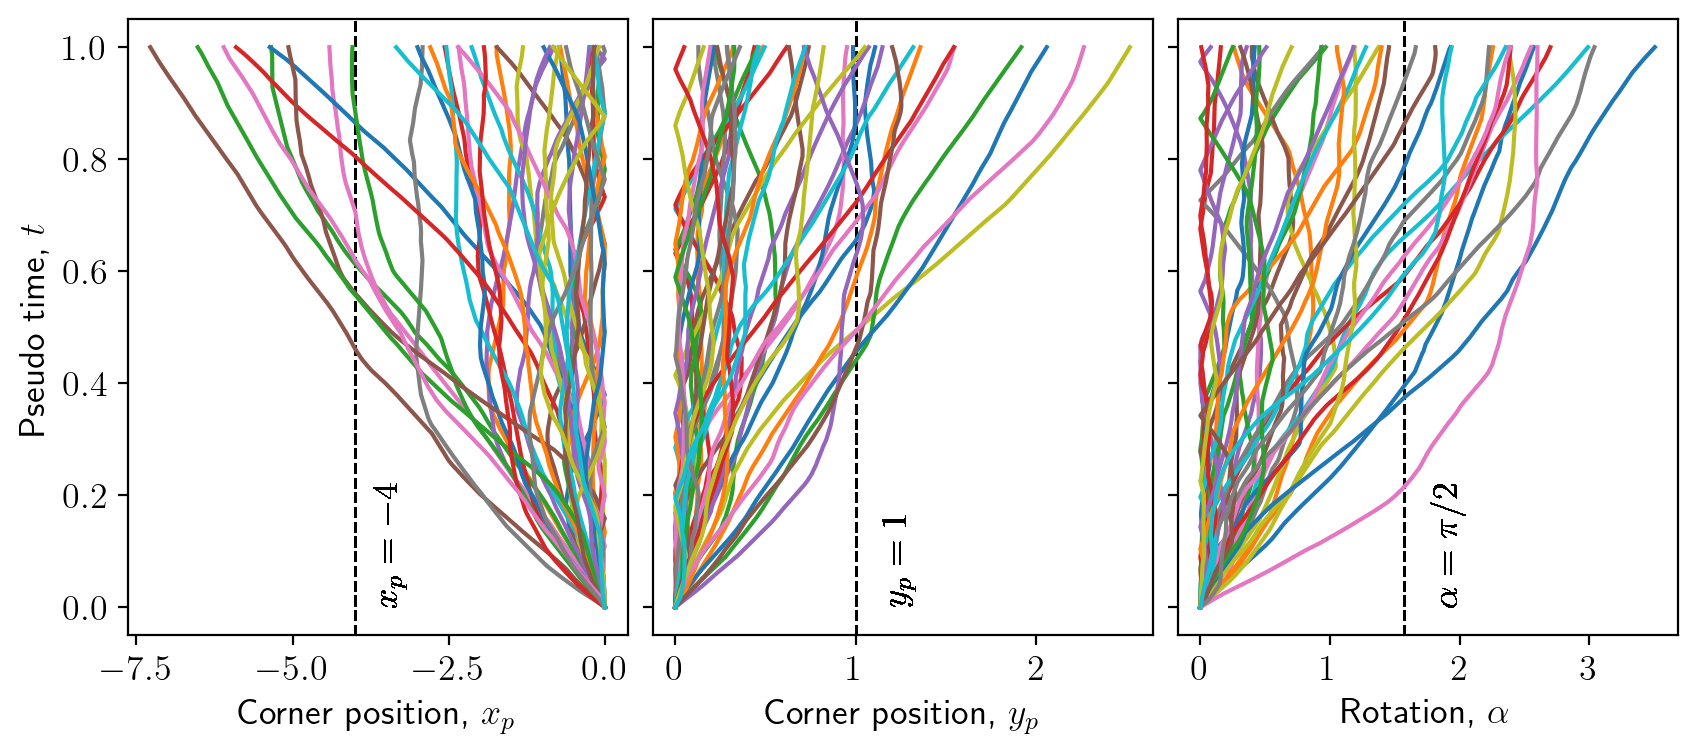

In [8]:
t = torch.linspace(0, 1, 1000)
f, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)
for seed in range(0, 200, 5):
    torch.manual_seed(seed)
    model = SofaNet([128, 128, 128], alpha_scaling=2.8, xp_scaling=3.2, yp_scaling=2.4)
    alpha, xp, yp, dt_alpha, dt_xp, dt_yp = model(t)
    ax[2].plot(alpha.detach(), t)
    ax[2].axvline(torch.pi / 2, c='k', zorder=1, ls="--", lw=1)
    ax[2].text(torch.pi / 2 + .2, 0, "$\\alpha=\pi/2$", ha="left", va="bottom", fontsize=13, rotation=90)
    ax[0].plot(xp.detach(), t)
    ax[0].axvline(-4, c='k', zorder=1, ls="--", lw=1)
    ax[0].text(-3.7, 0, "$x_p=-4$", ha="left", va="bottom", fontsize=13, rotation=90)
    ax[1].axvline(1, c='k', zorder=1, ls="--", lw=1)
    ax[1].text(1.15, 0, "$y_p=1$", ha="left", va="bottom", fontsize=13, rotation=90)
    ax[1].plot(yp.detach(), t)
    ax[0].set_ylabel("Pseudo time, $t$", fontsize=13)
    ax[2].set_xlabel("Rotation, $\\alpha$", fontsize=13)
    ax[0].set_xlabel("Corner position, $x_p$", fontsize=13)
    ax[1].set_xlabel("Corner position, $y_p$", fontsize=13)
    for x in ax:
        x.tick_params(axis='both', which='major', labelsize=13)
    # ax[0].set_ylim(0, 1)
    # ax[1].set_ylim(0, 1)
    # ax[2].set_ylim(0, 1)
plt.savefig("figs/init.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

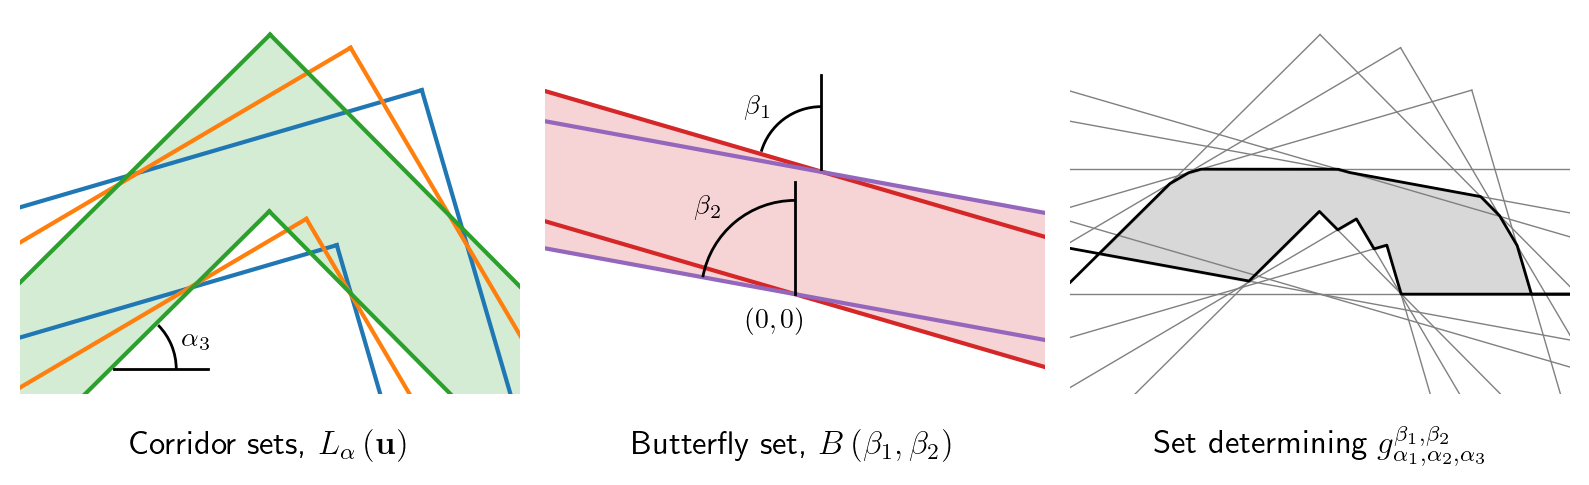

In [9]:
gg = torch.load(f"figs/data/eq28_geometry.pt")
for key in gg.keys():
    gg[key] = gg[key].detach()

f, axes = plt.subplots(1, 3, dpi=200, figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=0.05)
ax = axes[0]
for i in range(len(gg["x_lhi"])):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], c=colors[i])
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], c=colors[i])
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], c=colors[i])
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], c=colors[i])
# area sample
n_areas = 10000
x_sample = torch.linspace(0., 1., n_areas, device=xp.device)
x_min, x_max = -5., 5
x_sample = x_min + x_sample * (x_max - x_min)
interp_lvi = interp1d_multi_lines(gg[f"x_lvi"][-1:], gg[f"y_lvi"][-1:], x_sample, min_for_reduce=False)
interp_lhi = interp1d_multi_lines(gg[f"x_lhi"][-1:], gg[f"y_lhi"][-1:], x_sample, min_for_reduce=False)
y_sample_lower = torch.maximum(interp_lvi, interp_lhi)
interp_lvo = interp1d_multi_lines(gg[f"x_lvo"][-1:], gg[f"y_lvo"][-1:], x_sample, min_for_reduce=True)
interp_lho = interp1d_multi_lines(gg[f"x_lho"][-1:], gg[f"y_lho"][-1:], x_sample, min_for_reduce=True)
y_sample_upper = torch.minimum(interp_lvo, interp_lho)
ax.fill_between(x_sample, y1=y_sample_lower, y2=y_sample_upper, color=colors[i], alpha=.2)
ax.plot([-1.75 + .5, -1 + .5], [-.6, -.6], c='k', lw=1)
ax.add_patch(Arc([-1.75 + .5, -.6], 1, 1, theta1=0, theta2=44.76))
ax.text(-1.2 + .5, -.6 + .15, "$\\alpha_3$", ha="left", va="bottom")
ax.set_title("Corridor sets, $L_{\\alpha}\\left(\\mathbf{u}\\right)$", y=-0.2)

ax = axes[1]
ax.plot(gg["x_bvi"][0], gg["y_bvi"][0], c=colors[i + 1])
ax.plot(gg["x_bvo"][0], gg["y_bvo"][0], c=colors[i + 1])
ax.plot(gg["x_bvi"][1], gg["y_bvi"][1], c=colors[i + 2])
ax.plot(gg["x_bvo"][1], gg["y_bvo"][1], c=colors[i + 2])
interp_bvi = interp1d_multi_lines(gg[f"x_bvi"], gg[f"y_bvi"], x_sample, min_for_reduce=True)
interp_bvo = interp1d_multi_lines(gg[f"x_bvo"], gg[f"y_bvo"], x_sample, min_for_reduce=False)
ax.fill_between(x_sample, y1=interp_bvi, y2=interp_bvo, color=colors[i + 1], alpha=.2)
ax.plot([0, 0], [0, .9], c='k', lw=1)
ax.add_patch(Arc([0, 0], 1.5, 1.5, theta1=90, theta2=90 + 79.6, zorder=100))
ax.text(-0.7, 0.7, "$\\beta_2$", ha="center", va="center")
ax.text(.1, -.1, "$(0, 0)$", ha="right", va="top")
ax.plot([.21, .21], [1, 1 + .75], c='k', lw=1)
ax.add_patch(Arc([.21, 1], 1, 1, theta1=90, theta2=90 + 73.7, zorder=100))
ax.text(-0.3, 1.5, "$\\beta_1$", ha="center", va="center")
ax.set_title("Butterfly set, $B\\left(\\beta_1, \\beta_2\\right)$", y=-0.2)

ax = axes[2]
for i in range(len(gg["x_lhi"])):
    ax.plot(gg["x_lhi"][i], gg["y_lhi"][i], c='gray', lw=.5)
    ax.plot(gg["x_lvi"][i], gg["y_lvi"][i], c='gray', lw=.5)
    ax.plot(gg["x_lho"][i], gg["y_lho"][i], c='gray', lw=.5)
    ax.plot(gg["x_lvo"][i], gg["y_lvo"][i], c='gray', lw=.5)
ax.plot(gg["x_bvi"][0], gg["y_bvi"][0], c='gray', lw=.5)
ax.plot(gg["x_bvo"][0], gg["y_bvo"][0], c='gray', lw=.5)
ax.plot(gg["x_bvi"][1], gg["y_bvi"][1], c='gray', lw=.5)
ax.plot(gg["x_bvo"][1], gg["y_bvo"][1], c='gray', lw=.5)
ax.plot([-10, 10], [1, 1], c='gray', lw=.5)
ax.plot([-10, 10], [0, 0], c='gray', lw=.5)
plt.plot(gg["x_sample"], gg["y_sample_lower"], c='k', lw=1)
plt.plot(gg["x_sample"], gg["y_sample_upper"], c='k', lw=1)
plt.plot([gg["x_sample"][-1], gg["x_sample"][-1]],
         [gg["y_sample_lower"][-1], gg["y_sample_upper"][-1]], c='k', lw=1)
ax.fill_between(gg["x_sample"], y1=gg["y_sample_lower"], y2=gg["y_sample_upper"],
                where=gg["y_sample_upper"] > gg["y_sample_lower"],
                color="gray", alpha=.3)
ax.set_title("Set determining $g_{\\alpha_1,\\alpha_2,\\alpha_3}^{\\beta_1, \\beta_2}$", y=-0.2)

for ax in axes:
    ax.set_xlim(-2., 2)
    ax.set_ylim(-.8, 2.2)
    ax.set_aspect(1.)
    ax.axis("off")
plt.savefig("figs/set.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

In [10]:
# plt.figure(dpi=200, figsize=(10, 6))
# ax = plt.gca()
# 
# ns = torch.cat((torch.arange(10, 100, 10), torch.arange(100, 3001, 100)))
# areas = []
# for n in ns:
#     out_dir = f"outputs/upper/eq15_{n}"
#     gg = torch.load(f"{out_dir}/best_geometry.pt")
#     for key in gg.keys():
#         gg[key] = gg[key].detach()
#     areas.append(gg["area"])
# plt.axhline(2.2195, label="Gerver's area: 2.2195", c=colors[3], lw=2)
# plt.plot(ns, areas, label="Kallus-Romik upper bounds",
#          marker="o", markersize=7, lw=2)
# fs = 20
# plt.gca().tick_params(axis='both', which='major', labelsize=fs)
# plt.legend(fontsize=fs)
# plt.xlabel("Number of angles, $n$", labelpad=10, fontsize=fs)
# plt.ylabel("Sofa area bound, $G_{\gamma_1, \gamma_2, \cdots, \gamma_{n-2}}^{\gamma_{n-1}, \gamma_{n}}$",
#            labelpad=15, fontsize=fs)
# plt.savefig("figs/upper_bound.pdf", bbox_inches="tight", pad_inches=0.01)
# plt.show()

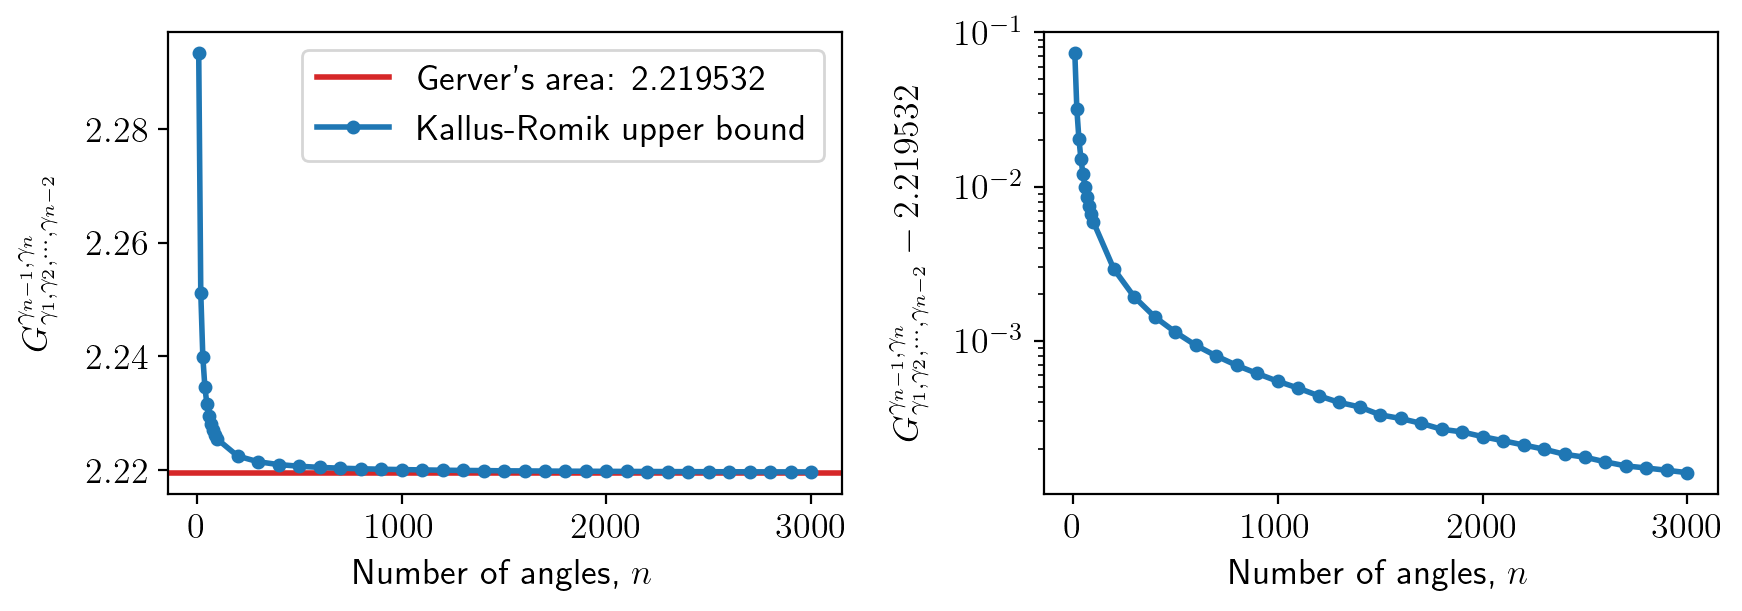

In [11]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(10, 3))
plt.subplots_adjust(wspace=.3)
ax = axes[0]
ns = torch.cat((torch.arange(10, 100, 10), torch.arange(100, 3001, 100)))
areas = []
for n in ns:
    out_dir = f"outputs/upper/eq15_{n}"
    gg = torch.load(f"{out_dir}/best_geometry.pt")
    for key in gg.keys():
        gg[key] = gg[key].detach()
    areas.append(gg["area"])
ax.axhline(2.219532, label="Gerver's area: 2.219532", c=colors[3], lw=2)
ax.plot(ns, areas, label="Kallus-Romik upper bound",
        marker="o", markersize=4, lw=2)
fs = 13
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.legend(fontsize=fs)
ax.set_xlabel("Number of angles, $n$", labelpad=5, fontsize=fs)
ax.set_ylabel("$G_{\gamma_1, \gamma_2, \cdots, \gamma_{n-2}}^{\gamma_{n-1}, \gamma_{n}}$",
              labelpad=10, fontsize=fs)

ax = axes[1]
ax.plot(ns, torch.tensor(areas) - 2.219532, label="Kallus-Romik upper bound",
        marker="o", markersize=4, lw=2)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlabel("Number of angles, $n$", labelpad=5, fontsize=fs)
ax.set_ylabel("$G_{\gamma_1, \gamma_2, \cdots, \gamma_{n-2}}^{\gamma_{n-1}, \gamma_{n}}-2.219532$",
              labelpad=10, fontsize=fs)

plt.savefig("figs/upper.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

In [12]:
print(ns[torch.abs(torch.tensor(areas) - 1.01 * 2.219532).argmin()])
print(ns[torch.abs(torch.tensor(areas) - 1.001 * 2.219532).argmin()])
print(ns[torch.abs(torch.tensor(areas) - 1.0001 * 2.219532).argmin()])

tensor(30)
tensor(300)
tensor(2100)


In [13]:
# load model
from upper.network import SofaNet as SofaNetU
from upper.geometry import compute_area as compute_area_u


def area_func(x):
    return compute_area_u(alpha, torch.pi / 2, torch.pi / 2, x[:nu], x[nu:], n_areas=10000)


def area_mesh(a, n=101):
    dps = torch.linspace(-a, a, n)
    dqs = torch.linspace(-a, a, n)
    area_all = torch.zeros((n, n))
    for ip, dp in enumerate(dps):
        for iq, dq in enumerate(dqs):
            x = vp * dp + vq * dq + u12
            area_all[ip, iq] = area_func(x)
    return torch.meshgrid(dps, dqs, indexing="ij"), area_all


model = SofaNetU([128, 128, 128])
model.load_state_dict(torch.load("figs/data/eq26_model.pt"))

# compute area
a1 = 0.283794109  # asin(7/25)
a2 = 0.532504098  # asin(33/65)
a3 = 0.781214087  # asin(119/169)
a4 = 1.03829223  # asin(56/65)
a5 = 1.28700222  # asin(24/25)
alpha = torch.tensor([a1, a2, a3, a4, a5])
u1, u2 = model.forward(alpha)
area = compute_area_u(alpha, torch.pi / 2, torch.pi / 2, u1, u2, n_areas=10000)
print(area.item())

torch.manual_seed(0)
vp = torch.randn(10)
vq = torch.randn(10)

nu = 5
u12 = torch.cat((u1, u2)).detach()
(p_pm1, q_pm1), area_pm1 = area_mesh(1, 101)

2.333695650100708


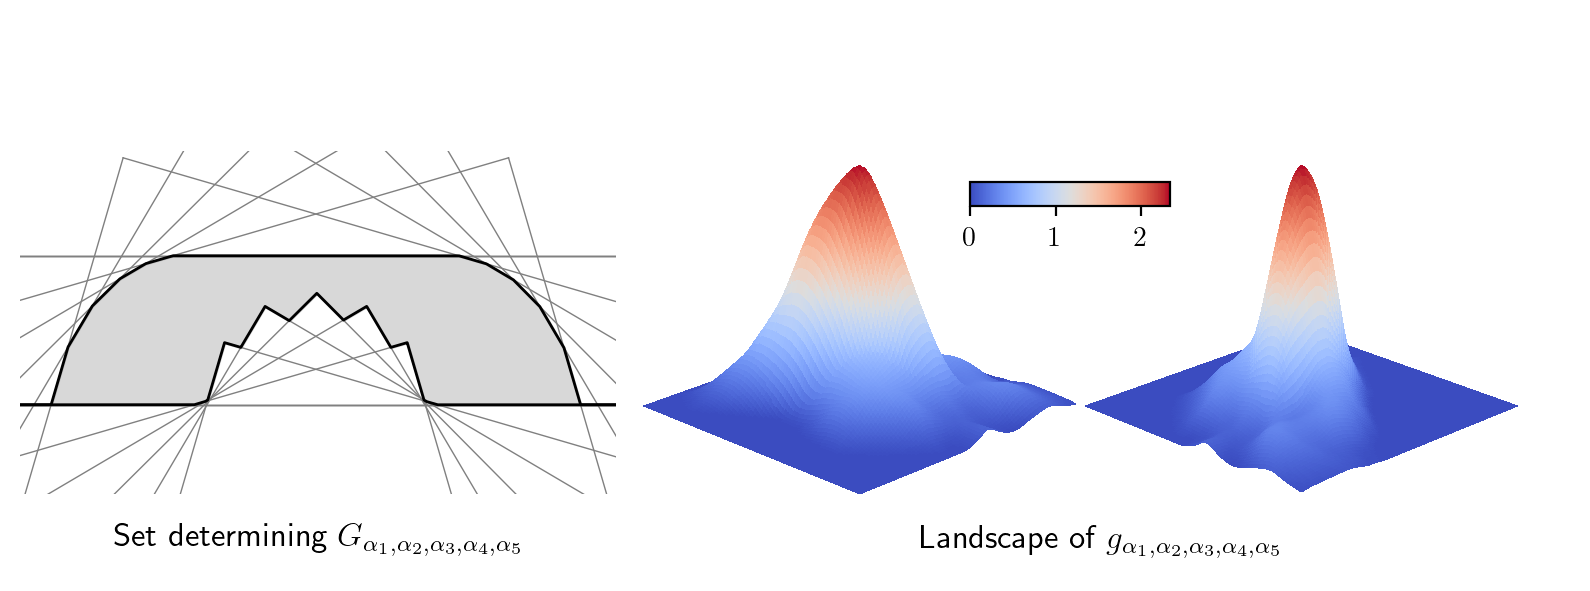

In [14]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

gg = torch.load(f"figs/data/eq26_geometry.pt")
for key in gg.keys():
    gg[key] = gg[key].detach()

fig = plt.figure(dpi=200, figsize=(10, 4))
gs = GridSpec(1, 2, width_ratios=[1.5, 2.5], wspace=-.05)
ax0 = plt.subplot(gs[0])
for i in range(len(gg["x_lhi"])):
    ax0.plot(gg["x_lhi"][i], gg["y_lhi"][i], c='gray', lw=.5)
    ax0.plot(gg["x_lvi"][i], gg["y_lvi"][i], c='gray', lw=.5)
    ax0.plot(gg["x_lho"][i], gg["y_lho"][i], c='gray', lw=.5)
    ax0.plot(gg["x_lvo"][i], gg["y_lvo"][i], c='gray', lw=.5)
ax0.plot(gg["x_bvi"][0], gg["y_bvi"][0], c='gray', lw=.5)
ax0.plot(gg["x_bvo"][0], gg["y_bvo"][0], c='gray', lw=.5)
ax0.plot(gg["x_bvi"][1], gg["y_bvi"][1], c='gray', lw=.5)
ax0.plot(gg["x_bvo"][1], gg["y_bvo"][1], c='gray', lw=.5)
ax0.plot([-10, 10], [1, 1], c='gray', lw=.5)
ax0.plot([-10, 10], [0, 0], c='gray', lw=.5)
plt.plot(gg["x_sample"], gg["y_sample_lower"], c='k', lw=1)
plt.plot(gg["x_sample"], gg["y_sample_upper"], c='k', lw=1)
plt.plot([gg["x_sample"][-1], gg["x_sample"][-1]],
         [gg["y_sample_lower"][-1], gg["y_sample_upper"][-1]], c='k', lw=1)
ax0.fill_between(gg["x_sample"], y1=gg["y_sample_lower"], y2=gg["y_sample_upper"],
                where=gg["y_sample_upper"] > gg["y_sample_lower"],
                color="gray", alpha=.3)
ax0.set_title("Set determining $G_{\\alpha_1,\\alpha_2,\\alpha_3, \\alpha_4, \\alpha_5}$", y=-0.2)
ax0.set_xlim(-2.1, 1.9)
ax0.set_ylim(-.6, 1.7)
ax0.set_aspect(1.)
ax0.axis("off")
ax0.set_anchor("S")

gs1 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], wspace=-.2)
ax = plt.subplot(gs1[0], projection="3d")
ax.view_init(elev=20, azim=45)
ax.plot_surface(p_pm1, q_pm1, area_pm1, cmap='coolwarm', rstride=1, cstride=1,
                vmin=area_pm1.min(), vmax=area_pm1.max(), antialiased=False)
plt.subplots_adjust(wspace=0.0)
ax.set_title("Landscape of $g_{\\alpha_1,\\alpha_2,\\alpha_3, \\alpha_4, \\alpha_5}$", y=0.014, x=.95)
ax.axis("off")
ax.set_facecolor('none')
ax.set_anchor((0.5, -1.2))

ax = plt.subplot(gs1[1], projection="3d")
ax.view_init(elev=20, azim=135)
surf = ax.plot_surface(p_pm1, q_pm1, area_pm1, cmap='coolwarm', rstride=1, cstride=1,
                       vmin=area_pm1.min(), vmax=area_pm1.max(), antialiased=False)
plt.subplots_adjust(wspace=0.0)
ax.axis("off")
ax.set_facecolor('none')
ax.set_anchor((0.5, -1.2))
cax = fig.add_axes([0.6, 0.47, 0.1, 0.03])  # [left, bottom, width, height]
fig.colorbar(surf, cax=cax, orientation='horizontal', ticks=[0, 1, 2])

plt.savefig("figs/gland.pdf", bbox_inches="tight", pad_inches=0.01)
plt.show()

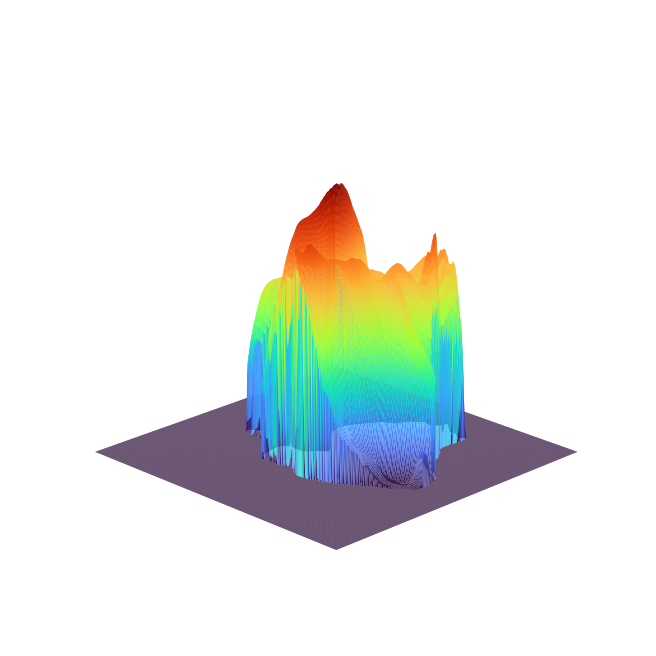

In [15]:
fig = plt.figure(dpi=200, figsize=(10, 4))
areas = torch.load("./figs/data/areas_300.pt")
ax = plt.subplot(111, projection="3d")
ax.view_init(elev=20, azim=45)
x, y = torch.meshgrid(torch.linspace(-1, 1, 301),
                      torch.linspace(-1, 1, 301), indexing="ij")
ax.plot_surface(x, y, areas, cmap='turbo', rstride=1, cstride=1,
                vmin=areas.min(), vmax=areas.max())
ax.axis("off")
ax.set_facecolor('none')
plt.show()

In [16]:
import numpy as np
import pyvtk

height_factor = .8

npoint = 301
nelem = npoint - 1
connectivity = np.zeros((nelem ** 2, 4), dtype=int)
connectivity[:, 0] = ((np.arange(nelem) * nelem)[:, None] + np.arange(nelem)[None, :]).reshape(-1)
connectivity[:, 1] = connectivity[:, 0] + 1
connectivity[:, 2] = connectivity[:, 0] + nelem + 1
connectivity[:, 3] = connectivity[:, 0] + nelem

# vtk mesh
xyz = np.ndarray((npoint * npoint, 3))
x, y = np.meshgrid(np.linspace(-1, 1, npoint), np.linspace(-1, 1, npoint), indexing="ij")
xyz[:, 0] = x.reshape(-1)
xyz[:, 1] = y.reshape(-1)
xyz[:, 2] = areas.reshape(-1) * height_factor
vtk_mesh = pyvtk.UnstructuredGrid(list(zip(xyz[:, 0], xyz[:, 1], xyz[:, 2])),
                                  quad=list(zip(connectivity[:, 0], connectivity[:, 1], connectivity[:, 2],
                                                connectivity[:, 3])))

# loop over time to write vtk
vtk = pyvtk.VtkData(vtk_mesh, pyvtk.PointData(pyvtk.Scalars(areas.reshape(-1).numpy(), name='A')))
vtk.tofile('figs/data/surface.vtk', 'binary')